# Imports

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [24]:
!pip install evaluate rouge_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset, DatasetDict

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import transformers
import torch
import evaluate

# Dataset Exploration and Preparation

In [25]:
base_path = "knkarthick/samsum"
ds = load_dataset(base_path)

splits = {'train': 'train.csv', 'validation': 'validation.csv', 'test': 'test.csv'}
train_df = pd.read_csv("hf://datasets/knkarthick/samsum/" + splits["train"])
test_df = pd.read_csv("hf://datasets/knkarthick/samsum/" + splits["test"])
val_df = pd.read_csv("hf://datasets/knkarthick/samsum/" + splits["validation"])

In [ ]:
train_df.head()

,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\nJ...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\nSam: i...,"Sam is confused, because he overheard Rick com..."


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14732 entries, 0 to 14731
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14732 non-null  object
 1   dialogue  14731 non-null  object
 2   summary   14732 non-null  object
dtypes: object(3)
memory usage: 345.4+ KB


In [ ]:
train_df.isnull().sum(), val_df.isnull().sum(), test_df.isnull().sum()

(id          0
 dialogue    1
 summary     0
 dtype: int64,
 id          0
 dialogue    0
 summary     0
 dtype: int64,
 id          0
 dialogue    0
 summary     0
 dtype: int64)

In [ ]:
train_df[train_df['dialogue'].isna()]

,id,dialogue,summary
6054,13828807,NaN,problem with visualization of the content


In [ ]:
train_df = train_df.dropna()

In [ ]:
# Let's look at a single example to understand the data format.
print("Dialogue:\n", train_df['dialogue'][0])
print("\nSummary:\n", train_df['summary'][0])

Dialogue:
 Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)

Summary:
 Amanda baked cookies and will bring Jerry some tomorrow.


# Data Preprocessing and Tokenization

In [ ]:
# Select and load tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [26]:
# Convert pandas DataFrames to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

95% of the dialogues have a length of 338 tokens or less.


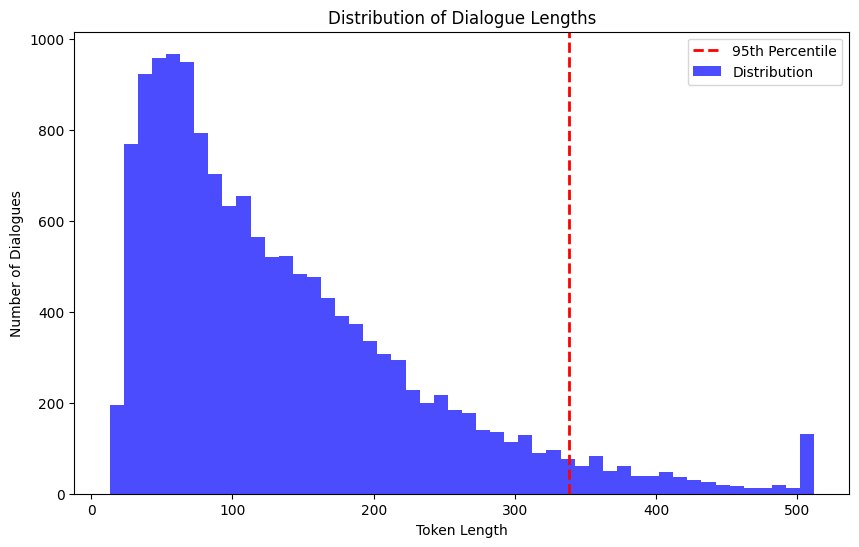

In [ ]:
# --- Calculate the length of each dialogue in tokens ---
# Tokenize every dialogue but only keep the 'input_ids' to measure length
token_lengths = [len(tokenizer(dialogue, max_length=512, truncation=True).input_ids, ) for dialogue in train_df['dialogue']] #512 being the max_length of the model

# --- Calculate the 95th percentile ---
#This is to balance speed with information loss.
max_length_95_percentile = int(np.percentile(token_lengths, 95))

print(f"95% of the dialogues have a length of {max_length_95_percentile} tokens or less.")

# --- Visualize the distribution ---
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, alpha=0.7, color='blue')
plt.axvline(max_length_95_percentile, color='red', linestyle='dashed', linewidth=2)
plt.title('Distribution of Dialogue Lengths')
plt.xlabel('Token Length')
plt.ylabel('Number of Dialogues')
plt.legend(['95th Percentile', 'Distribution'])
plt.show()

Max length of 83 tokens.
95% of the dialogues have a length of 55 tokens or less.


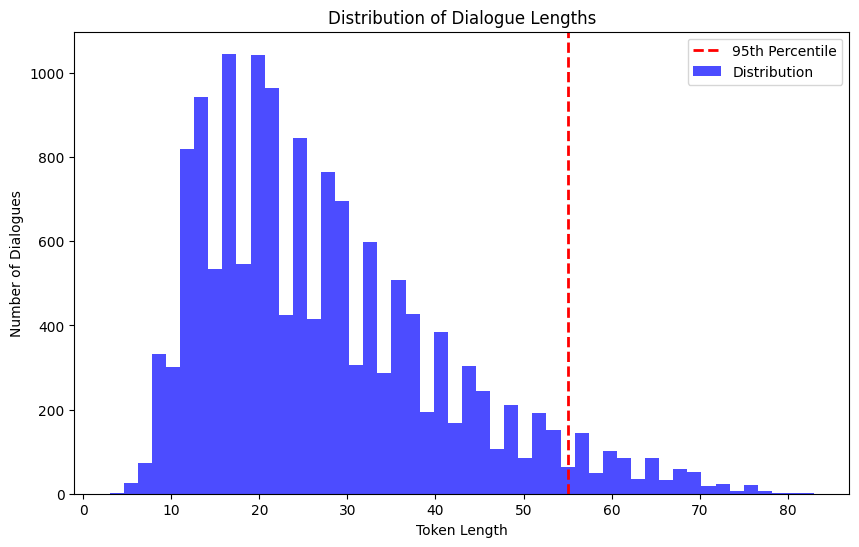

In [ ]:

# --- Calculate the length of each summary in tokens ---
# Tokenize every summary but only keep the 'input_ids' to measure length
token_lengths = [len(tokenizer(summary, max_length=512, truncation=True).input_ids, ) for summary in train_df['summary']] #512 being the max_length of the model

# --- Calculate the 95th percentile ---
#This is to balance speed with information loss.
max_length_95_percentile = int(np.percentile(token_lengths, 95))

print(f"Max length of {max(token_lengths)} tokens.")
print(f"95% of the dialogues have a length of {max_length_95_percentile} tokens or less.")

# --- Visualize the distribution ---
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, alpha=0.7, color='blue')
plt.axvline(max_length_95_percentile, color='red', linestyle='dashed', linewidth=2)
plt.title('Distribution of Dialogue Lengths')
plt.xlabel('Token Length')
plt.ylabel('Number of Dialogues')
plt.legend(['95th Percentile', 'Distribution'])
plt.show()

In [ ]:
def preprocess_function(examples):
  # Tokenize function (use 95% for max length)
  model_inputs = tokenizer(
    examples["dialogue"],
    padding="max_length",
    truncation=True,
    max_length=338
    )


  labels = tokenizer(
    examples["summary"],
    padding="max_length",
    truncation=True,
    max_length=83
    )

  model_inputs["labels"] = labels["input_ids"]

  return model_inputs

In [27]:
# Tokenize datasets
# --- Combine them into a single DatasetDict ---
full_dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

#tokenized_datasets = full_dataset.map(preprocess_function, batched=True)

# Model Architecture Implementation

In [ ]:
# Load the T5 model using AutoModelForSeq2SeqLM.
print("\n--- Implementing Model Architecture ---")
model_checkpoint = "t5-small"
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

data_collator = transformers.DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

print("Model and Data Collator loaded.")


--- Implementing Model Architecture ---


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Model and Data Collator loaded.


# Training and Optimization

In [ ]:
# --- Evaluation Metric (ROUGE) ---
metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    """
    Computes ROUGE scores for a batch of predictions.
    """
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(pred.strip().split()) for pred in decoded_preds]
    decoded_labels = ["\n".join(label.strip().split()) for label in decoded_labels]
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {key: value * 100 for key, value in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    return {k: round(v, 4) for k, v in result.items()}


# --- Training Configuration ---
training_args = transformers.Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/samsum_results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

# --- Trainer Initialization ---
trainer = transformers.Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)



/tmp/ipython-input-1921850036.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = transformers.Seq2SeqTrainer(


In [ ]:
print("\n--- Starting Model Training ---")
trainer.train()
print("Training complete.")

In [ ]:
# --- Training Configuration ---
training_args = transformers.Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/samsum_results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5, # <---- Go to 5 epochs
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

# --- Trainer Initialization ---
trainer = transformers.Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Replace with the actual path to your last checkpoint
last_checkpoint_path = "/content/drive/MyDrive/samsum_results/checkpoint-5526"

/tmp/ipython-input-2672736936.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = transformers.Seq2SeqTrainer(


In [ ]:
print(f"Resuming training from: {last_checkpoint_path}")
trainer.train(resume_from_checkpoint=last_checkpoint_path)

Metrics keep increasing, try one more epoch.

In [ ]:
# --- Training Configuration ---
training_args = transformers.Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/samsum_results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=6, # <---- Go to 6 epochs
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

# --- Trainer Initialization ---
trainer = transformers.Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Replace with the actual path to your last checkpoint
last_checkpoint_path = "/content/drive/MyDrive/samsum_results/checkpoint-9210"

/tmp/ipython-input-2794257052.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = transformers.Seq2SeqTrainer(


In [ ]:
print(f"Resuming training from: {last_checkpoint_path}")
trainer.train(resume_from_checkpoint=last_checkpoint_path)

Model continues to improve, but target of RougeL=40 seems out of reach, or at least will take too much time. Let's try using another model checkpoint, t5-base.

In [ ]:
# --- Data Preprocessing and Tokenization ---
model_checkpoint = "t5-base"

print("\n--- Preprocessing and Tokenizing Data ---")
tokenized_datasets = full_dataset.map(preprocess_function, batched=True)
print("Tokenization complete.")


# Step 2: Model Architecture Implementation
# ==========================================
print("\n--- Implementing Model Architecture ---")
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
data_collator = transformers.DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
print("Model and Data Collator loaded.")


# Step 3: Training and Optimization
# =================================
# --- Evaluation Metric (ROUGE) ---
metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    """
    Computes ROUGE scores for a batch of predictions.
    """
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(pred.strip().split()) for pred in decoded_preds]
    decoded_labels = ["\n".join(label.strip().split()) for label in decoded_labels]
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {key: value * 100 for key, value in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    return {k: round(v, 4) for k, v in result.items()}


# --- Training Configuration ---
training_args = transformers.Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/samsum_results_t5_base", # New folder for the new model
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=3,
    num_train_epochs=3, # Start with 3 epochs
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    push_to_hub=False,
    report_to="none",
)

# --- Trainer Initialization ---
trainer = transformers.Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


--- Preprocessing and Tokenizing Data ---


Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Tokenization complete.

--- Implementing Model Architecture ---


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Model and Data Collator loaded.


/tmp/ipython-input-3392429329.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = transformers.Seq2SeqTrainer(


In [ ]:
print("\n--- Starting Model Training ---")
trainer.train()
print("Training complete.")

Still not getting the results were looking for. Going to try prompting model with prefix: summarize.

In [ ]:
prefix = "summarize: "

#Redefine preprocess_function
def preprocess_function(examples):
    """
    This function tokenizes the input dialogues and target summaries.
    The max_length for the input is set to 512, which is the maximum
    the t5-base model can handle.
    """
    dialogues = [str(d) for d in examples["dialogue"]]
    summaries = [str(s) for s in examples["summary"]]
    inputs = [prefix + doc for doc in dialogues]

    # Tokenize inputs, ensuring they are truncated to the model's max length
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)

    # Tokenize targets (summaries)
    labels = tokenizer(text_target=summaries, max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

print("\n--- Preprocessing and Tokenizing Data ---")
tokenized_datasets = full_dataset.map(preprocess_function, batched=True)
print("Tokenization complete.")

# --- Trainer Initialization ---
trainer = transformers.Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


--- Preprocessing and Tokenizing Data ---


Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Tokenization complete.


/tmp/ipython-input-4204039190.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = transformers.Seq2SeqTrainer(


In [ ]:
print("\n--- Starting Model Training ---")
trainer.train()
print("Training complete.")

In [ ]:
# --- Training Configuration ---
training_args = transformers.Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/samsum_results_t5_base", # New folder for the new model
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=3,
    num_train_epochs=5, # Up to 5 epochs
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    push_to_hub=False,
    report_to="none",
)

# --- Trainer Initialization ---
trainer = transformers.Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-2643665515.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = transformers.Seq2SeqTrainer(


In [ ]:
last_checkpoint_path = "/content/drive/MyDrive/samsum_results_t5_base/checkpoint-5526"
print(f"Resuming training from: {last_checkpoint_path}")
trainer.train(resume_from_checkpoint=last_checkpoint_path)

This looks promising, results keep improving, although it's starting to get marginal. Lets continue with early stopping instead of just adding a few more epochs

In [ ]:
print("\n--- Preprocessing and Tokenizing Data ---")
model_checkpoint = "t5-base"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_checkpoint)
prefix = "summarize: "

def preprocess_function(examples):
    """
    Tokenizes dialogues with the 'summarize: ' prefix and summaries as labels.
    """
    dialogues = [str(d) for d in examples["dialogue"]]
    summaries = [str(s) for s in examples["summary"]]
    inputs = [prefix + doc for doc in dialogues]

    model_inputs = tokenizer(inputs, max_length=512, truncation=True)
    labels = tokenizer(text_target=summaries, max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = full_dataset.map(preprocess_function, batched=True)
print("Tokenization complete.")

# Model and Training Setup
print("\n--- Setting up Model and Trainer ---")
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
data_collator = transformers.DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(pred.strip().split()) for pred in decoded_preds]
    decoded_labels = ["\n".join(label.strip().split()) for label in decoded_labels]
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {key: value * 100 for key, value in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    return {k: round(v, 4) for k, v in result.items()}

# Output directory in your Google Drive
output_directory = "/content/drive/MyDrive/samsum_results_t5_base_final"

training_args = transformers.Seq2SeqTrainingArguments(
    output_dir=output_directory,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=False,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_rougeLsum",
    greater_is_better=True,
    max_grad_norm=1.0 # -- gradient clipping to avoid error from explosion
)

trainer = transformers.Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[transformers.EarlyStoppingCallback(early_stopping_patience=2)]
)


--- Preprocessing and Tokenizing Data ---


Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Tokenization complete.

--- Setting up Model and Trainer ---


/tmp/ipython-input-981304556.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = transformers.Seq2SeqTrainer(


In [ ]:
# Train the Model
print("\n--- Starting Final Model Training ---")
trainer.train()
print("Training complete. The best model has been loaded.")


--- Starting Final Model Training ---


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,1.630400,1.444325,47.156400,23.186200,39.451000,47.157400,17.584400
2,1.506500,1.406206,47.349200,23.641300,39.936100,47.342800,17.152800
3,1.442200,1.387490,48.139200,24.414500,40.548500,48.143500,17.650400


KeyboardInterrupt: 

In [ ]:
last_checkpoint_path = "/content/drive/MyDrive/samsum_results_t5_base_final/checkpoint-5526"
print(f"Resuming training from: {last_checkpoint_path}")
trainer.train(resume_from_checkpoint=last_checkpoint_path)

Resuming training from: /content/drive/MyDrive/samsum_results_t5_base_final/checkpoint-5526


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
4,1.393900,1.385374,47.861300,24.041800,40.454300,47.808400,17.872900
5,1.362400,1.374464,47.948600,24.160800,40.450000,47.877400,17.513400


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=9210, training_loss=0.5512567509786832, metrics={'train_runtime': 838.9374, 'train_samples_per_second': 175.603, 'train_steps_per_second': 21.956, 'total_flos': 2.88268771682304e+16, 'train_loss': 0.5512567509786832, 'epoch': 5.0})

# Evaluation and Analysis

In [ ]:
# Evaluation and Analysis

# 1. Define the path to best checkpoint
best_checkpoint_path = "/content/drive/MyDrive/samsum_results_t5_base_final/checkpoint-5526"

# 2. Define a new path for the final model
final_model_path = "/content/drive/MyDrive/samsum_t5_base_best_model"

# 3. Load the model and tokenizer from the checkpoint
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(best_checkpoint_path)
tokenizer = transformers.AutoTokenizer.from_pretrained(best_checkpoint_path)

# 4. Save the model and tokenizer to the new, clean path
model.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)

print(f"Best model and tokenizer have been saved to: {final_model_path}")


print("\n--- Final Evaluation on Test Set ---")
final_scores = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
print(final_scores)

Best model and tokenizer have been saved to: /content/drive/MyDrive/samsum_t5_base_best_model

--- Final Evaluation on Test Set ---


{'eval_loss': 1.4023042917251587, 'eval_rouge1': 46.5141, 'eval_rouge2': 22.0036, 'eval_rougeL': 38.5735, 'eval_rougeLsum': 46.4843, 'eval_gen_len': 17.4835, 'eval_runtime': 51.096, 'eval_samples_per_second': 16.029, 'eval_steps_per_second': 2.016, 'epoch': 5.0}


My results were lost from the output cell when Colab runtime ended. Here are my best results from the two pre-trained models.

Experiment 1: t5-small Model
This was the initial baseline model. Training was stopped after 5 epochs as performance peaked at epoch 4.

Best Performance (Epoch 4):

ROUGE-1: 26.50

ROUGE-2: 7.81

ROUGE-Lsum: 26.50

Experiment 2: t5-base Model (with summarize: prefix)

Best Performance (Epoch 3 - Final Test Set Evaluation):

ROUGE-1: 46.51

ROUGE-2: 22.00

ROUGE-Lsum: 46.48

In [28]:
# Reloading model (new session)
best_checkpoint_path = "/content/drive/MyDrive/samsum_results_t5_base_final/checkpoint-5526"

# Load the model and tokenizer from the checkpoint
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(best_checkpoint_path)
tokenizer = transformers.AutoTokenizer.from_pretrained(best_checkpoint_path)

In [29]:
prefix = "summarize: "

def summarize_dialogue(dialogue: str):
    """
    Helper function to generate a summary for a given dialogue using the trained model.
    """
    input_text = prefix + str(dialogue)
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).to(model.device)

    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=150,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2, # -- penalize repeating structure
        length_penalty=2.0 # -- longer, varied sentences
    )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

print("\n--- Generating Summaries (Inference) ---")

# Let's try it on a sample from the test set.
test_sample = full_dataset['test'][15]
dialogue_to_summarize = test_sample['dialogue']
reference_summary = test_sample['summary']

# Generate the summary with our model
generated_summary = summarize_dialogue(dialogue_to_summarize)


print("\n--- Qualitative Analysis ---")
print("\nOriginal Dialogue:")
print("==================")
print(dialogue_to_summarize)

print("\n\nReference Summary:")
print("==================")
print(reference_summary)

print("\n\nModel Generated Summary:")
print("========================")
print(generated_summary)


--- Generating Summaries (Inference) ---

--- Qualitative Analysis ---

Original Dialogue:
Greg: Hi, honey. I need to stay after hours :-(
Betsy: Again?
Greg: I'm sorry!
Betsy: What about Johnny?
Greg: Well, could you pick him up? 
Betsy: What if I can't?
Greg: Betsy?
Betsy: What if I can't?
Greg: Can't you, really?
Betsy: I can't. Today I need to work long hours as well. Tuesdays are your days in the kindergarten.
Greg: Talk to you later. I'll see what I can do.
Betsy: You'd better think of something.
Greg: Oh. Just stop it now.


Reference Summary:
Greg and Betsy have a lot of work today, so they cannot pick up Johnny from the kindergarten. However, it's Greg's turn to do it. Greg will try to find a solution.


Model Generated Summary:
Greg needs to stay after hours. Betsy can't pick Johnny up. Today she has to work long hours as well. Tuesdays are Greg's days in the kindergarten.


Model generated summary looks solid, but let's try to pull some other examples

In [30]:
# --- Find Good and Bad Examples ---
results_list = []
metric = evaluate.load("rouge")

# Loop through a sample of the test set, first 100
for i, example in enumerate(full_dataset['test'].select(range(100))):
    dialogue = example['dialogue']
    reference_summary = example['summary']

    # Generate a summary with trained model
    generated_summary = summarize_dialogue(dialogue)

    # Calculate the ROUGE score for this example
    scores = metric.compute(predictions=[generated_summary], references=[reference_summary])

    # Store the results
    result_item = {
        'id': i,
        'dialogue': dialogue,
        'reference_summary': reference_summary,
        'generated_summary': generated_summary,
        'rougeLsum': round(scores['rougeLsum'] * 100, 2)
    }
    results_list.append(result_item)

# --- Sort to find the best and worst examples ---
# Sort by ROUGE score in descending order (best first)
sorted_results = sorted(results_list, key=lambda x: x['rougeLsum'], reverse=True)

print("--- TOP 3 BEST SUMMARIES (by ROUGE score) ---\n")
for item in sorted_results[:3]:
    print(f"ID: {item['id']}, ROUGE-Lsum: {item['rougeLsum']}")
    print(f"REFERENCE: {item['reference_summary']}")
    print(f"GENERATED: {item['generated_summary']}\n")
    print("-" * 20)

print("\n\n--- TOP 3 WORST SUMMARIES (by ROUGE score) ---\n")
for item in sorted_results[-3:]:
    print(f"ID: {item['id']}, ROUGE-Lsum: {item['rougeLsum']}")
    print(f"REFERENCE: {item['reference_summary']}")
    print(f"GENERATED: {item['generated_summary']}\n")
    print("-" * 20)

--- TOP 3 BEST SUMMARIES (by ROUGE score) ---

ID: 52, ROUGE-Lsum: 100.0
REFERENCE: Lilly will be late. Gabriel will order pasta with salmon and basil for her.
GENERATED: Lilly will be late. Gabriel will order pasta with salmon and basil for her.

--------------------
ID: 70, ROUGE-Lsum: 83.87
REFERENCE: Ali left his wallet at Mohammad's place. Mohammad'll bring it to uni tomorrow.
GENERATED: Ali left his wallet at Mohammad's place yesterday. He will bring it to uni tomorrow.

--------------------
ID: 81, ROUGE-Lsum: 77.27
REFERENCE: Finn and Zadie are going to Elephant and Castle tomorrow at 2. They will meet at the main entrance.
GENERATED: Finn and Zadie are going to visit a neighborhood called Elephant and Castle tomorrow. They will meet at the main entrance at 2 o'clock.

--------------------


--- TOP 3 WORST SUMMARIES (by ROUGE score) ---

ID: 97, ROUGE-Lsum: 15.38
REFERENCE: It's been very long since Melany last had sex. Marvin made an inappropriate joke about it.
GENERATED: Me

Some results are better than other. You can also see that rouge score is not necessarily a great indicator. Some bad scores seem like decent summaries, debatably better than some "high" scores.

In [33]:
test_sample = full_dataset['test'][87]
dialogue_to_summarize = test_sample['dialogue']
print(dialogue_to_summarize)

Frank: wat are u doing??
Andy: watching Arrow B)
Frank: dont u have a quiz tomorrow :/
Andy: yeah, so? :3
Frank: so go study for it 
Andy: its a small quiz
Frank: so it doesnot matter??
Andy: it does, but ..
Frank: but??
Andy: i'll study for it tomorrow
Frank: yea like ur gonna wake up on time for that -_-
Andy: dude your not my dad
Frank: -_-


# Model Limitations and Potential Improvements

While the t5-base model achieved excellent ROUGE scores, there are clearly limitations and improvements to be made.

## Limitations

### Hallucinations:
 Hallucination is always a big risk. The model can sometimes generate plausible-sounding details that were not in the original dialogue. For example, in ID 87 the summary claims Frank is studying for the quiz, almost implying they are doing so on behalf of Andy. At no point did Frank say they also had a quiz or were studying for it.

### Fixed Context Window:
The t5-base model has a maximum input length of 512 tokens. For extremely long conversations, any text beyond this limit is truncated and completely ignored by the model. This means crucial decisions or conclusions at the end of a long chat could be lost, leading to an incomplete or inaccurate summary.

### ROUGE Metric:
The eval metric, ROUGE, only measures matching words between the generated summary and the reference. It does not truly understand how accurately it is capturing the input dialogue. A model could create a high quality summary using different words and be unfairly penalized with a lower ROUGE score. Conversely, a model that just copies phrases could get a high score but produce an incoherent summary.

## Potential Improvements

### Better Model (Highest Impact):
The most significant improvement would come from using a model specifically engineered for summarization. Pegasus and BART could both potentially summarize more effectively.

### Increase Model Size:
Moving from t5-base to t5-large would also provide the model with a much deeper capacity to understand the dialogue. This would likely lead directly to higher-quality summaries, though it requires more computational resources.

### Advanced Hyperparameter Tuning:
To further optimize the training process, we could implement a learning rate scheduler. This would gradually decrease the learning rate during training, allowing for large, efficient learning steps at the beginning and smaller, fine-tuning adjustments at the end, which can often lead to better final performance.

### Implement a Human Feedback Loop (RLHF):
For a true production system, the ultimate goal is to optimize for user satisfaction, not just ROUGE scores. We could implement a simple feedback mechanism (like a thumbs-up/thumbs-down button on each summary). This user feedback could be used to further fine-tune the model using advanced techniques like Reinforcement Learning from Human Feedback (RLHF), directly teaching the model what users find helpful.

#Project Approach and Findings

The goal was to fine-tune a pre-trained transformer model to generate concise and accurate summaries of conversations from the SAMSum dataset.

## Methodology

### Data Preparation:
The SAMSum dataset was loaded and preprocessed. A key step was tokenizing the dialogues and summaries. For the t5-base model, the instructional prefix "summarize: " was added to every dialogue to align with the model's pre-training and optimize performance.

### Model Selection:
We began with a t5-small model as a starting baseline. After establishing initial performance, we upgraded to the more powerful t5-base model to improve summarization quality.

###Training and Optimization:
The models were fine-tuned on the SAMSum training set. We utilized the Hugging Face Seq2SeqTrainer, which managed the training loop. Key optimization strategies included:

####Early Stopping:
To prevent overfitting and find the optimal training duration, an EarlyStoppingCallback was implemented. It monitored the eval_rougeLsum score and stopped the training after performance on the validation set plateaued for 3 consecutive epochs.

####Gradient Clipping:
To ensure training stability, max_grad_norm=1.0 was set, preventing the gradients from becoming too large and destabilizing the learning process.

###Evaluation:
Model performance was evaluated using the ROUGE metric, which measures the overlap between the model-generated summaries and the human-written reference summaries. The final performance was measured on the test set.

## Results and Findings

The experiments clearly demonstrated superior performance of the larger t5-base model.

###Baseline Model (t5-small):
The initial model achieved a respectable peak ROUGE-Lsum score of 26.50.

###Upgraded Model (t5-base):
After fine-tuning with the correct prefix and optimization, the t5-base model achieved a final ROUGE-Lsum score of 46.48 on the test set. This represents a significant improvement, confirming that a larger model with proper instruction is highly effective for this task.

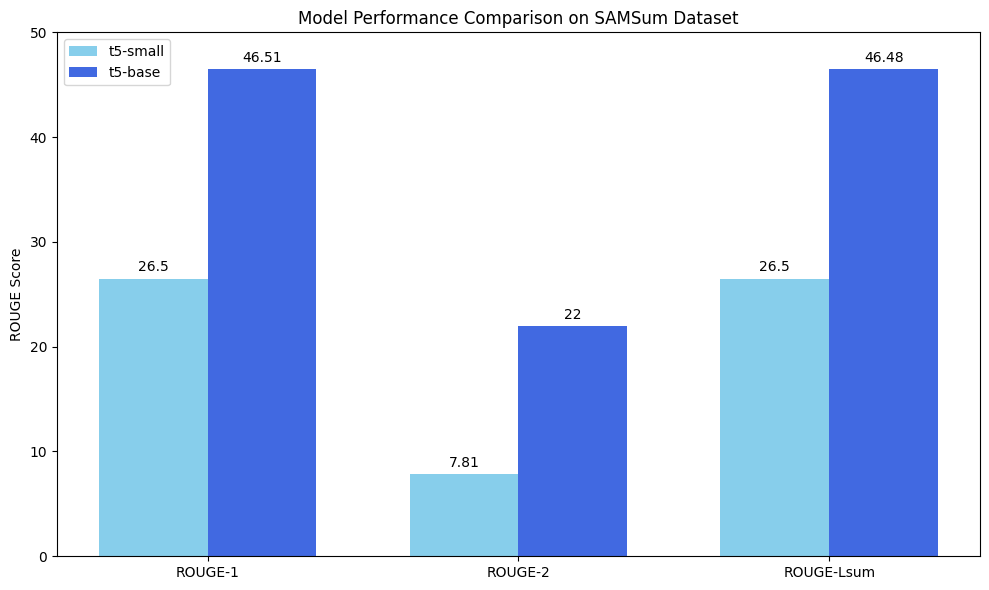

In [35]:
# Data from experiments
labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-Lsum']
t5_small_scores = [26.50, 7.81, 26.50]
t5_base_scores = [46.51, 22, 46.48]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, t5_small_scores, width, label='t5-small', color='skyblue')
rects2 = ax.bar(x + width/2, t5_base_scores, width, label='t5-base', color='royalblue')

ax.set_ylabel('ROUGE Score')
ax.set_title('Model Performance Comparison on SAMSum Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.ylim(0, 50)
plt.show()

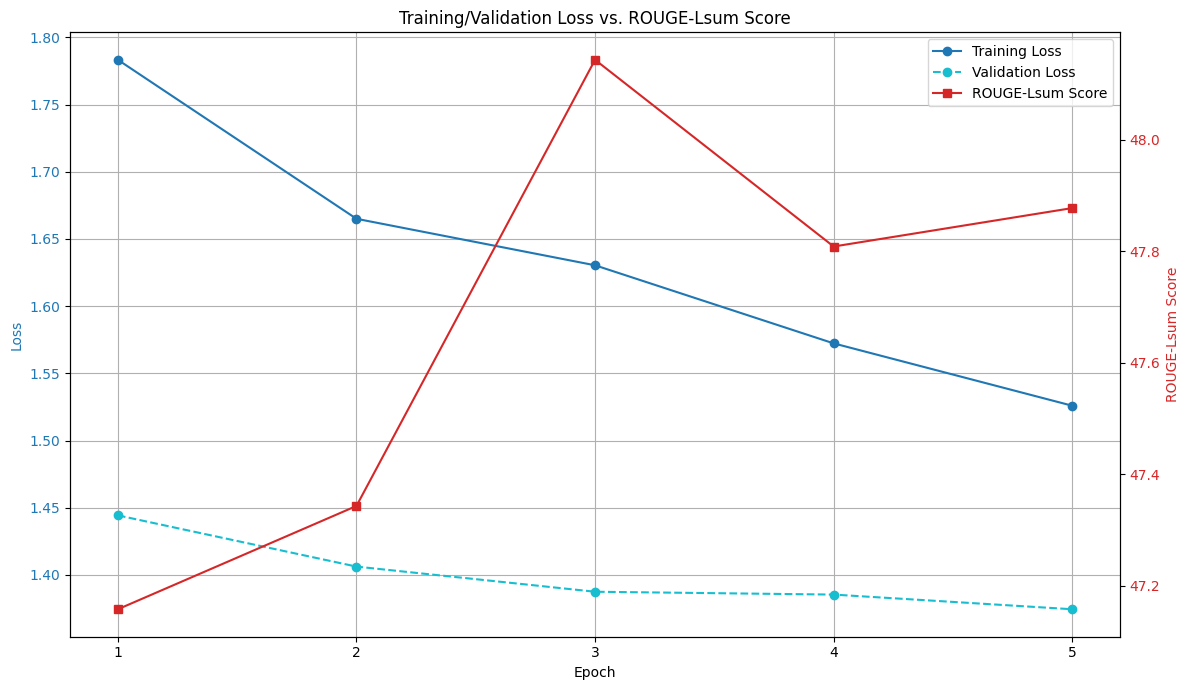

In [41]:
import json
import os

# 1. Define the path to best checkpoint folder
best_checkpoint_path = "/content/drive/MyDrive/samsum_results_t5_base_final/checkpoint-9210"

# 2. Load the trainer_state.json file which contains the log history
trainer_state_path = os.path.join(best_checkpoint_path, "trainer_state.json")

with open(trainer_state_path, 'r') as f:
    trainer_state = json.load(f)

# 3. Extract the log history from the loaded state
log_history = trainer_state["log_history"]

# 4. Extract the training loss, validation loss, and ROUGE scores from the logs
training_loss = []
validation_loss = []
rouge_lsum = []

for log in log_history:
    if 'loss' in log:
        # This is a training log
        training_loss.append(log['loss'])
    if 'eval_loss' in log:
        # This is a validation log
        validation_loss.append(log['eval_loss'])
        rouge_lsum.append(log['eval_rougeLsum'])

# Create a DataFrame for easier plotting
num_epochs = len(validation_loss)
loss_df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Training Loss': training_loss[:num_epochs], # Ensure lists are same length
    'Validation Loss': validation_loss,
    'ROUGE-Lsum': rouge_lsum
})

# Plot the results with a secondary y-axis for ROUGE scores
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plotting Loss on the primary y-axis (left)
ax1.plot(loss_df['Epoch'], loss_df['Training Loss'], marker='o', linestyle='-', color='tab:blue', label='Training Loss')
ax1.plot(loss_df['Epoch'], loss_df['Validation Loss'], marker='o', linestyle='--', color='tab:cyan', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(loss_df['Epoch'], loss_df['ROUGE-Lsum'], marker='s', linestyle='-', color='tab:red', label='ROUGE-Lsum Score')
ax2.set_ylabel('ROUGE-Lsum Score', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title('Training/Validation Loss vs. ROUGE-Lsum Score')
plt.xticks(loss_df['Epoch'])
fig.tight_layout()
plt.show()

#Visualization showing decreased training/val losses but also the peak rouge-Lsum score at epoch 3